In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load Dataset

In [4]:
data = []
with open('./data/sample_coco.txt', 'r') as s:
    for l in s.readlines():
        data.append(eval("{" + re.sub(r'([a-z]+)', r'"\1"', l) + "}"))

In [5]:
df = pd.read_json(json.dumps(data))

In [6]:
df["bbx"] = df['bbox'].map(lambda bb: bb[0])
df["bby"] = df['bbox'].map(lambda bb: bb[1])
df["bbw"] = df['bbox'].map(lambda bb: bb[2])
df["bbh"] = df['bbox'].map(lambda bb: bb[3])
df.drop('bbox', axis=1, inplace=True)

In [7]:
classes = {
    0: u'__background__',
    1: u'person',
    2: u'bicycle',
    3: u'car',
    4: u'motorcycle',
    5: u'airplane',
    6: u'bus',
    7: u'train',
    8: u'truck',
    9: u'boat',
    10: u'traffic light',
    11: u'fire hydrant',
    12: u'stop sign',
    13: u'parking meter',
    14: u'bench',
    15: u'bird',
    16: u'cat',
    17: u'dog',
    18: u'horse',
    19: u'sheep',
    20: u'cow',
    21: u'elephant',
    22: u'bear',
    23: u'zebra',
    24: u'giraffe',
    25: u'backpack',
    26: u'umbrella',
    27: u'handbag',
    28: u'tie',
    29: u'suitcase',
    30: u'frisbee',
    31: u'skis',
    32: u'snowboard',
    33: u'sports ball',
    34: u'kite',
    35: u'baseball bat',
    36: u'baseball glove',
    37: u'skateboard',
    38: u'surfboard',
    39: u'tennis racket',
    40: u'bottle',
    41: u'wine glass',
    42: u'cup',
    43: u'fork',
    44: u'knife',
    45: u'spoon',
    46: u'bowl',
    47: u'banana',
    48: u'apple',
    49: u'sandwich',
    50: u'orange',
    51: u'broccoli',
    52: u'carrot',
    53: u'hot dog',
    54: u'pizza',
    55: u'donut',
    56: u'cake',
    57: u'chair',
    58: u'couch',
    59: u'potted plant',
    60: u'bed',
    61: u'dining table',
    62: u'toilet',
    63: u'tv',
    64: u'laptop',
    65: u'mouse',
    66: u'remote',
    67: u'keyboard',
    68: u'cell phone',
    69: u'microwave',
    70: u'oven',
    71: u'toaster',
    72: u'sink',
    73: u'refrigerator',
    74: u'book',
    75: u'clock',
    76: u'vase',
    77: u'scissors',
    78: u'teddy bear',
    79: u'hair drier',
    80: u'toothbrush'
}

def get_class(i):
    return classes[i]

In [8]:
df['class'] = df['id'].map(get_class)

## Calculate Class Spread

In [9]:
class_spread = dict(df['class'].value_counts())
class_spread = dict(sorted(class_spread.items(), key=lambda item: item[0]))

In [10]:
df['class'].value_counts()

knife            153
clock            147
keyboard         145
tie              145
cow              142
                ... 
bed              106
hot dog          105
traffic light    102
boat             102
carrot           102
Name: class, Length: 80, dtype: int64

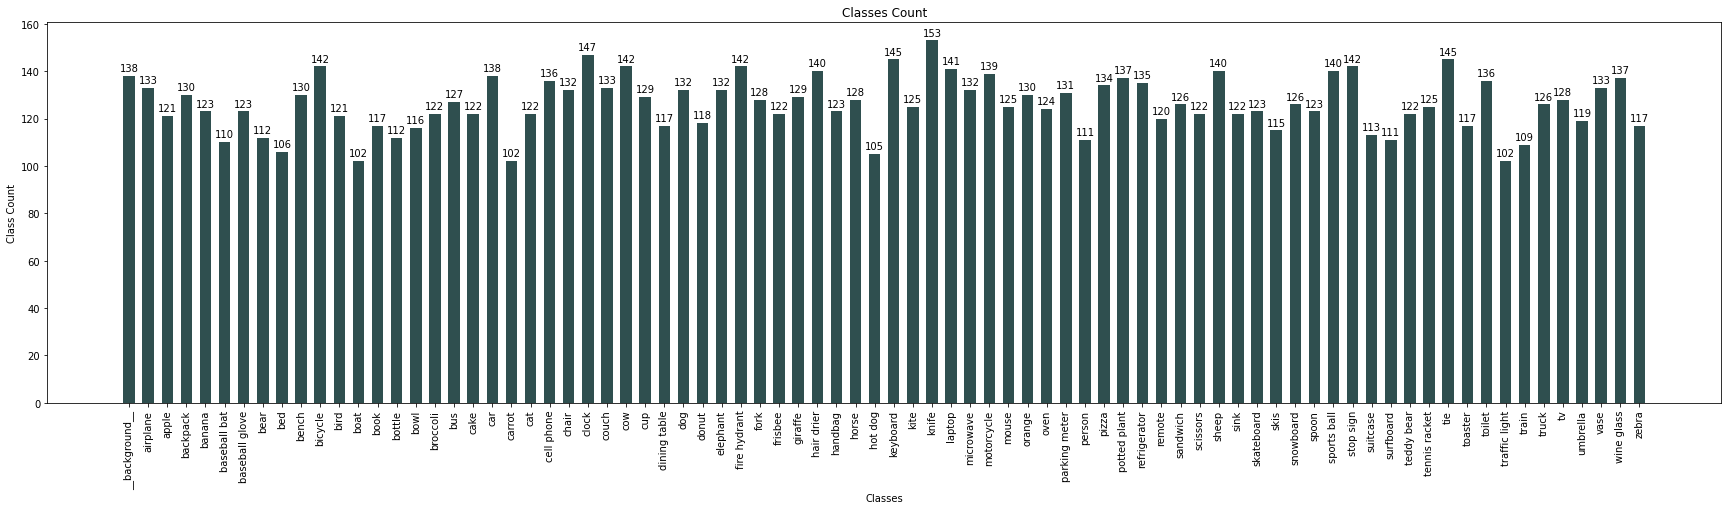

In [11]:
import matplotlib.pyplot as plt

data = class_spread
names = list(data.keys())
values = list(data.values())

plt.figure(figsize=(30, 7)) 
plt.bar(range(len(data)), values, tick_label=names, width=0.6, color='darkslategray')
for l in range(len(values)):
    plt.annotate(values[l], (-0.50 + l, values[l] + 2))
plt.xticks(rotation='90')
plt.xlabel("Classes")
plt.ylabel("Class Count")
plt.title("Classes Count")
plt.show()

## Calculate Anchor Boxes

In [12]:
df['nbbh'] = df['bbh']/df['height']
df['nbbw'] = df['bbw']/df['width']

nhwdf = df[['nbbw', 'nbbh']].copy()
nhwnp = np.array(nhwdf)
nhwdf.describe()

,nbbw,nbbh
count,10105.000000,10105.000000
mean,0.323393,0.325578
std,0.147178,0.145902
min,0.046964,0.047344
25%,0.211538,0.217931
50%,0.316785,0.320138
75%,0.414195,0.415625
max,0.894366,0.877551


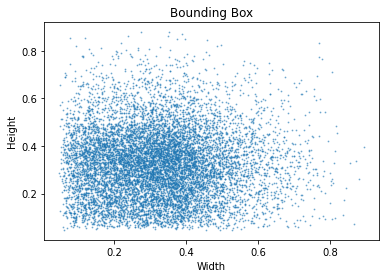

In [13]:
plt.scatter(nhwdf['nbbw'], nhwdf['nbbh'], s=3, marker='.', alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Bounding Box")
plt.show()

## Compute K-means

In [14]:
from sklearn.cluster import KMeans

In [15]:
# fitting multiple k-means algorithms and storing the values in an empty list
sse = []
centroids = []
predictions = []
clusters = list(range(3, 7))
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, init='k-means++')
    kmeans.fit(nhwnp)
    centroids.append(kmeans.cluster_centers_)
    sse.append(kmeans.inertia_)
    predictions.append(kmeans.predict(nhwnp))

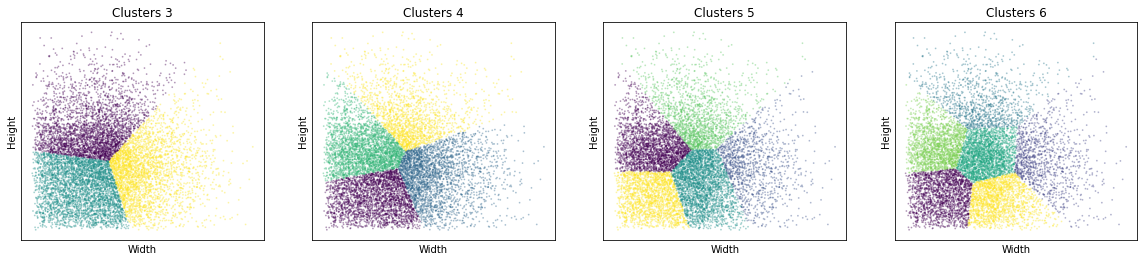

In [16]:
fig = plt.figure(figsize=(20, 4))

for i, c in zip(range(len(clusters)), clusters):
    ax = fig.add_subplot(1, len(clusters), i + 1, xticks=[], yticks=[])
    ax.set_title("Clusters "+str(c))
    ax.set_xlabel("Width")
    ax.set_ylabel("Height")
    plt.scatter(nhwdf['nbbw'], nhwdf['nbbh'], s=3, marker='.', alpha=0.3, c=predictions[i]/c)
plt.show()

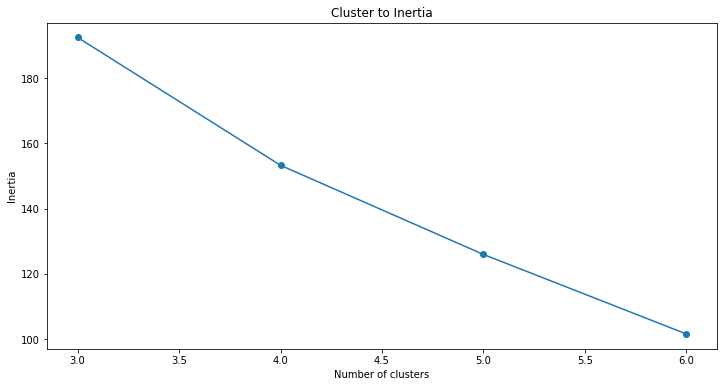

In [17]:
# converting the results into a dataframe and plotting them
plt.figure(figsize=(12,6))
plt.plot(clusters, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title("Cluster to Inertia")
plt.show()

## Calculate IOU for predicted boxes

In [18]:
def iou(x, centroids):
    dists = []
    for centroid in centroids:
        c_w, c_h = centroid
        w, h = x
        if c_w >= w and c_h >= h:
            dist = w * h / (c_w * c_h)
        elif c_w >= w and c_h <= h:
            dist = w * c_h / (w * h + (c_w - w) * c_h)
        elif c_w <= w and c_h >= h:
            dist = c_w * h / (w * h + c_w * (c_h - h))
        else:  # means both w,h are bigger than c_w and c_h respectively
            dist = (c_w * c_h) / (w * h)
        dists.append(dist)
    return np.array(dists)

def avg_iou(ious):
    n = ious.shape[0]
    sums = 0.
    for i in range(n):
        # note IOU() will return array which contains IoU for each centroid and X[i]
        # slightly ineffective, but I am too lazy
        sums += max(ious[i])
    return sums / n

In [19]:
ious = []
for c in range(len(clusters)):
    nhwdf['iou'+str(c)] = ious.append(avg_iou(np.array(nhwdf[['nbbw', 'nbbh']].apply(lambda r: iou((r['nbbw'], r['nbbh']), centroids[c]), axis=1))))

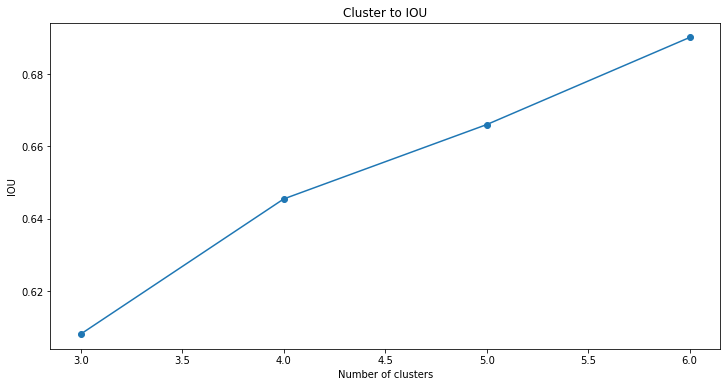

In [20]:
# converting the results into a dataframe and plotting them
plt.figure(figsize=(12,6))
plt.plot(clusters, ious, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('IOU')
plt.title("Cluster to IOU")
plt.show()

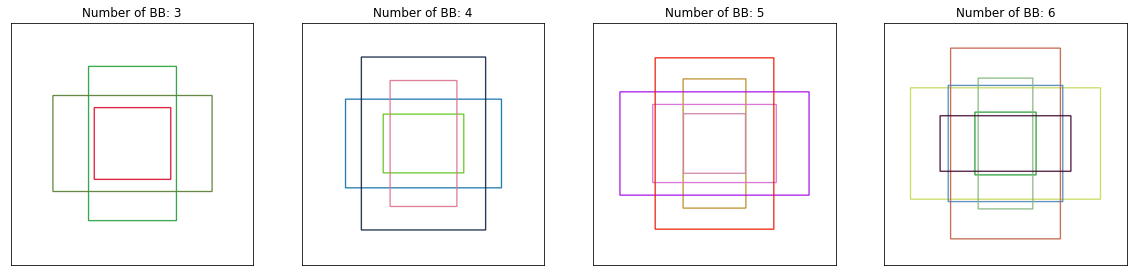

In [28]:
# Scale BB to 1000 times
import random
cox, coy = 300, 300

fig = plt.figure(figsize=(20, 5))

for k, exp in enumerate(centroids):
    image = cv2.resize(cv2.imread('./data/blank.jpg'), (600, 600), interpolation=cv2.INTER_AREA)
    for box in exp:
        # scale centroid by 1000 times
        cen = box*800/2
        # box start and end
        start_point = (int(cox-cen[0]), int(coy-cen[1]))
        end_point = (int(cox+cen[0]), int(coy+cen[1]))
        # Colour of BB
        color = (random.randint(0, 255+1), random.randint(0, 255+1), random.randint(0, 255+1))
        # Line thickness of 2 px
        thickness = 2

        # Using cv2.rectangle() method
        # Draw a rectangle with blue line borders of thickness of 2 px
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
    
    ax = fig.add_subplot(1, len(centroids), k + 1, xticks=[], yticks=[])
    ax.set_title("Number of BB: "+ str(len(exp)))
    plt.imshow(image)
plt.show()